In [1]:
import h5py
import numpy as np
from numpy import array, exp
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from scipy.optimize import curve_fit
import scipy
from scipy import stats
import time
import glob
import tables as tb
from scipy.signal import find_peaks
import spectroscopy_update as spec

In [2]:
# import the file. Just copy and paste the file path

f = h5py.File('D:/Documents/Berkeley Documents/Fall 2022/Detectors NE204/1012_co60.h5', 'r')

In [3]:
# See array of raw data

rdata = np.array(f['raw_data'])
rdf = pd.DataFrame(rdata)
rdf

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
0,7977,7984,7982,7982,7984,7978,7975,7982,7980,7977,...,7981,7981,7980,7982,7982,7982,7982,7982,7983,7977
1,7977,7979,7978,7980,7979,7975,7976,7976,7974,7973,...,8008,8012,8009,8015,8009,8008,8012,8011,8012,8012
2,7978,7977,7974,7977,7979,7975,7978,7978,7981,7979,...,8040,8039,8038,8038,8038,8040,8042,8040,8044,8046
3,7977,7969,7976,7975,7977,7979,7976,7974,7970,7975,...,7989,7986,7992,7988,7982,7986,7985,7985,7986,7984
4,7980,7971,7976,7977,7973,7976,7972,7974,7976,7978,...,7992,7987,7987,7985,7986,7985,7985,7986,7985,7987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16354,7976,7980,7979,7975,7974,7981,7977,7977,7978,7980,...,7983,7985,7984,7986,7988,7987,7988,7989,7986,7985
16355,7975,7978,7977,7979,7976,7972,7971,7978,7975,7976,...,7984,7984,7981,7986,7985,7983,7983,7984,7983,7981
16356,7977,7977,7979,7980,7978,7974,7977,7976,7976,7980,...,7988,7991,7991,7987,7988,7989,7990,7987,7990,7992
16357,7977,7974,7981,7972,7979,7979,7975,7980,7980,7980,...,7991,7982,7993,7986,7989,7991,7983,7989,7991,7986


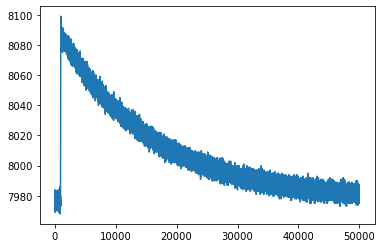

In [4]:
# plotting a single pulse

plt.plot(rdata[0,:])
plt.show()

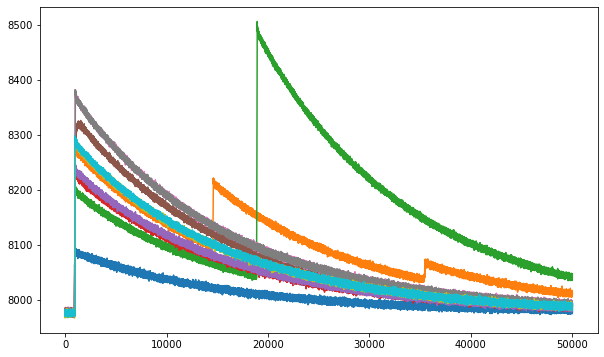

In [5]:
# Plotting multiple pulses

plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(rdata[i])
    
plt.show()
plt.close()

[ 115.64270891   58.58561328 7978.78305429]


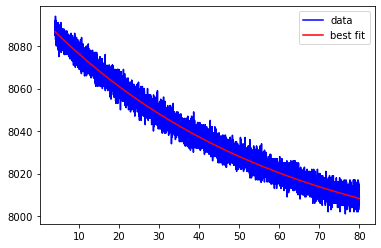

In [6]:
# Here is the curve fitting function to determine each pulse's decay constant

def func(x, a, b, c):
    return a*np.exp(-x/b)+c

xdata = np.arange(len(rdata[0,:]))*4e-9*1e6 # this changes from sample units to micro-seconds
xdata1 = xdata[1000:20000]
ydata = rdata[0,:]
ydata1 = ydata[1000:20000]
popt, pcov = curve_fit(func, xdata1, ydata1, p0=[150,8000,60], maxfev=5000) # p0 is starting point for a,b,c values
# maxfev is number of attempts python will make to zero in on the best fit
print(popt)

plt.plot(xdata1, ydata1, 'b-', label='data') # b- makes it a blue line and gives the line a name
plt.plot(xdata1, func(xdata1, *popt), 'r-', label='best fit') # r- makes it a red line
plt.legend()

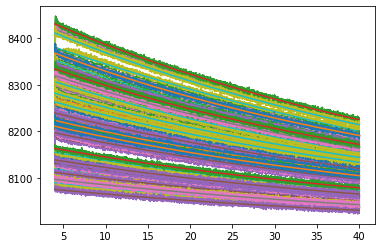

In [7]:
## This generates a decay constant for multiple pulses, but the output is not used in this code

tauarray=[]
for row in rdata[:100]:
    def func(x, a, b, c):
        return a*np.exp(-x/b)+c
    xdata = np.arange(len(row))*(4e-9)*(1e6)
    xdata1 = xdata[1000:10000]
    ydata = row[1000:10000]
    popt, pcov = curve_fit(func, xdata1, ydata, p0=[150,8000,60], maxfev=5000)
    tauarray.append(popt[1])
    plt.plot(xdata1, ydata)
    plt.plot(xdata1, func(xdata1, *popt))

In [8]:
# Remove the baseline, normalize to the highest pulse


def normalizer(v, baseline_idx = 200):
    baseline_mean = v[:,baseline_idx].mean()
    return (v-baseline_mean) / (v.max()-baseline_mean) 

# Turn an exponential waveform into a step function

def exp_to_step(v, tau):
    f = np.zeros_like(v)
    for n in range(v.shape[1]):
        if n==0:
            f[:, n] = 0
        if n!=0:
            f[:, n] = f[:, n-1] + v[:, n] - v[:, n-1]*(1-1/tau)
    return f

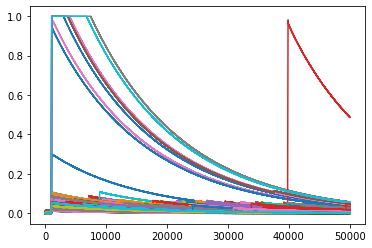

In [10]:
# Applying normalization to data file
# Visual proof of baseline correction and normalization

normalized_rdata = normalizer(rdata)
for i in range(5000):
    plt.plot(normalized_rdata[i, :])
plt.show()

In [18]:
tau = popt[1]
time_conv = 1e-6 / (4e-9)
tau_idx = tau*time_conv
tau_idx

12810.837565234231

In [14]:
# Apply step function filter to the normalized pulses

test_step = exp_to_step(normalized_rdata[0:5000, :], tau_idx)

In [15]:
np.shape(test_step)

(5000, 50000)

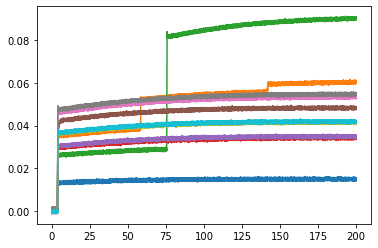

In [16]:
# Visualize the normalized step functions

for i in range(10):
    plt.plot(xdata, test_step[i,:])
plt.show()

In [17]:
# Here we define the trapezoid filter

def trap_filter(f, l, m):
    s = np.zeros_like(f)
    for n in range((2*l+m), f.shape[1]):
        if n==(2*l+m):
            s[:, n] = 0
        if n!=(2*l+m):
            s[:, n] = s[:, n-1] + f[:, n]-f[:, n-l-1]-f[:, n-l-m] + f[:, n-2*l-m-1]
    return s

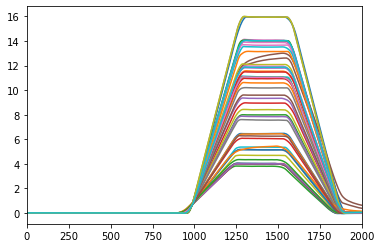

In [19]:
## Here we apply the trapezoid filter. Choose values for (l, m) to play with trapezoid gap/rise time.

test_trap = trap_filter(test_step[0:5000, :], 300, 300)
for i in range(50):
    plt.plot(test_trap[i,:])
plt.xlim(0, 2000)
plt.show()

In [20]:
test_trap[0]

array([0.        , 0.        , 0.        , ..., 0.01298634, 0.012747  ,
       0.01179379])

In [22]:
## Here we pull all the maximum values of each trapezoid

trap_peaks = []
for i in range(0, 5000):
    trap_peaks.append(np.max(test_trap[i]))

(1.0, 18.0)

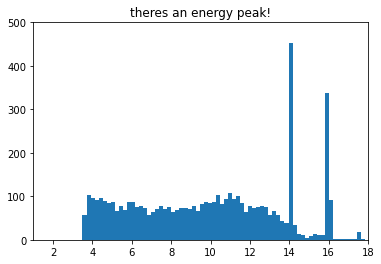

In [25]:
## here's a histogram of trap peaks that should produce a spike corresponding to Co-60 decay

plt.hist(trap_peaks, bins=1500)
plt.ylim(0,500)
plt.title('theres an energy peak!')
plt.xlim(1, 18)

[13.908 13.92  13.932 13.944 13.956 13.968 13.98  13.992 14.004 14.016
 14.028 14.04  14.052 14.064 14.076 14.088 14.1   14.112 14.124 14.136
 14.148 14.16  14.172 14.184 14.196]
[0.0000e+00 1.2000e-02 2.4000e-02 ... 1.7964e+01 1.7976e+01 1.7988e+01]


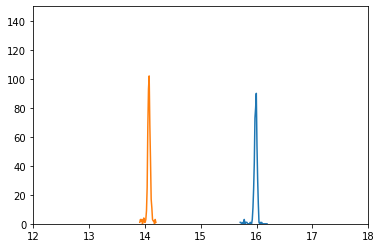

In [28]:
## Here we recreate the histogram
## Manually pare down "bins" and "n" to isolate the desired energy peak.

xmin = 0
xmax = 250
def gen_histogram(self, data, binsize=0.1):
        n, bins = np.histogram(trap_peaks, range=(0, 18), bins=(1500))
        return(n, bins[:])
n, bins = gen_histogram(trap_peaks, 1000)
n = np.array(n)
bins = np.array(bins[:-1])
#Here we isolate the first peak for Co-60
bins2 = bins[bins>13.9]
n2=n[bins>13.9]
bins3 = bins2[bins2<14.2]
n3=n2[bins2<14.2]
print(bins3)

#Here we isolate the second peak for Co-60
bins4 = bins[bins>15.7]
bins5 = bins4[bins4<16.2]
n4 = n[bins>15.7]
n5 = n4[bins4<16.2]
print(bins)


plt.plot(bins5, n5)
plt.plot(bins3,n3)
plt.ylim(0,150)
plt.xlim(12, 18)
plt.show()

0.02072673420321026


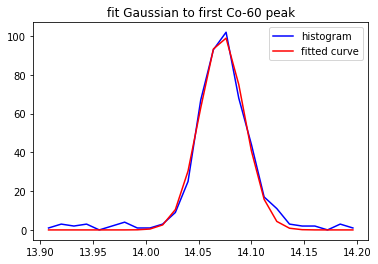

-0.02321933143593137


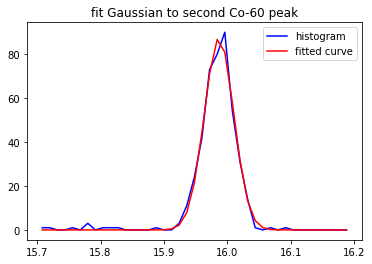

In [29]:
## Implement a Gaussian fit over the two peaks for Co-60

def gaus(x,a,x0,sigma):
     return a*np.exp(-(x-x0)**2/(2*sigma**2))
    # a is amplitude, x0 is mean, sigma is std_dev
# times = bins3, amplitude = n3

mean = sum(np.array(bins3)*np.array(n3))/sum(n3)            
sigma = np.sqrt(sum(np.array(n3)*(np.array(bins3)-mean)**2)/sum(n3))        

params,pcov = curve_fit(gaus, bins3, n3, p0=[max(n3),mean,sigma], maxfev=10000)
print(params[2])

plt.plot(bins3, n3, 'b', label='histogram')
plt.plot(bins3, gaus(np.array(bins3),*params),'r',  label="fitted curve")

plt.title("fit Gaussian to first Co-60 peak")
plt.legend()
plt.show()

mean2 = sum(np.array(bins5)*np.array(n5))/sum(n5)            
sigma2 = np.sqrt(sum(np.array(n5)*(np.array(bins5)-mean)**2)/sum(n5))        

params2,pcov = curve_fit(gaus, bins5, n5, p0=[max(n5),mean2,sigma2], maxfev=10000)
print(params2[2])

plt.plot(bins5, n5, 'b', label='histogram')
plt.plot(bins5, gaus(np.array(bins5),*params2),'r',  label="fitted curve")

plt.title("fit Gaussian to second Co-60 peak")
plt.legend()
plt.show()

In [30]:
# Find the FWHM, mean peak value, and resolution of the curve fit.

FWHM = 2*np.sqrt(2*np.log(2))*params[2]
print("mean value is", params[1])
print("FWHM in ADC channel for 1173 keV:")
with np.printoptions(precision=3):
    print(FWHM)

mean value is 14.072089107531111
FWHM in ADC channel for 1173 keV:
0.048807729169748106


In [31]:
FWHM2 = np.abs(2*np.sqrt(2*np.log(2))*params2[2])
print("mean value is", params2[1])
print("FWHM in ADC channel for 1333 keV:")
with np.printoptions(precision=3):
    print(np.abs(FWHM2))

mean value is 15.986931137581287
FWHM in ADC channel for 1333 keV:
0.05467734709754845
